In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

from nfl_pickem import Pickem

In [2]:
pk = Pickem()
print(pk.file_path)
df = pk.build_schedule()

../nfl-pickem/data/nfl_games.csv


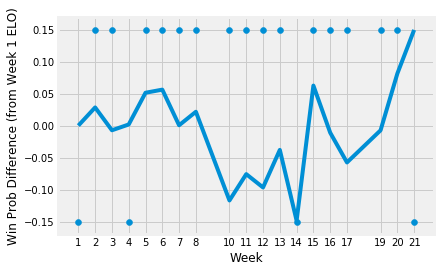

In [3]:
cond = df.team == 'NE'
plt.plot(df[cond].week.values,
         df[cond].win_pct.values - df[cond].elo_prob1.values)
plt.scatter(df[cond].week.values,
            0.3*df[cond].result1.values - 0.15)
plt.ylabel('Win Prob Difference (from Week 1 ELO)')
plt.xlabel('Week')
plt.xticks(df[cond].week.values,
           df[cond].week.values)
plt.show()

In [4]:
df

,index,date,season,neutral,playoff,team1,team2,elo1,elo2,elo_prob1,score1,score2,result1,weekday,week,home,elo1_week,elo2_week,team,win_pct
0,15742,2017-09-10,2017,0,0,PIT,CLE,1598.852911,1335.767660,0.757729,21,18,1,6,1,0,1598.852911,1335.767660,PIT,0.757729
1,15747,2017-09-10,2017,0,0,HOU,JAX,1502.139008,1381.984201,0.743804,7,29,0,6,1,1,1502.139008,1381.984201,HOU,0.743804
2,15754,2017-09-10,2017,0,0,DEN,LAC,1555.532966,1437.046156,0.741970,24,21,1,0,1,1,1555.532966,1437.046156,DEN,0.741970
3,15743,2017-09-10,2017,0,0,ATL,CHI,1617.204570,1383.934716,0.724848,23,17,1,6,1,0,1617.204570,1383.934716,ATL,0.724848
4,15740,2017-09-10,2017,0,0,NE,KC,1687.395154,1613.148952,0.690309,27,42,0,3,1,1,1687.395154,1613.148952,NE,0.690309
5,15751,2017-09-10,2017,0,0,CAR,SF,1526.877166,1353.459533,0.651151,23,3,1,6,1,0,1526.877166,1353.459533,CAR,0.651151
6,15752,2017-09-10,2017,0,0,DAL,NYG,1569.472083,1530.436026,0.645400,19,3,1,6,1,1,1569.472083,1530.436026,DAL,0.645400
7,15745,2017-09-10,2017,0,0,BUF,NYJ,1484.127683,1451.565526,0.636826,21,12,1,6,1,1,1484.127683,1451.565526,BUF,0.636826
8,15744,2017-09-10,2017,0,0,CIN,BAL,1515.969638,1491.099567,0.626524,0,20,0,6,1,1,1515.969638,1491.099567,CIN,0.626524
9,15750,2017-09-10,2017,0,0,GB,SEA,1586.722386,1570.901591,0.614257,17,9,1,6,1,1,1586.722386,1570.901591,GB,0.614257


In [7]:
df[df.week == 1].team1.unique().shape

(30,)

In [11]:
df = df[df.week < 18]

import pulp as pl

prob = pl.LpProblem("pickem problem", pl.LpMaximize)
picks = pl.LpVariable.dicts("pick", df.index.values, 0, 1, pl.LpInteger)

# One Pick Per Week
week_pick_mat = pd.crosstab(
    index=df.week, columns=df.index
)

week_map = [0] * week_pick_mat.shape[0]
for i, j in zip(*np.asarray(week_pick_mat).nonzero()):
    week_map[i] += week_pick_mat.iloc[i, j] * picks[j]

for i in range(week_pick_mat.shape[0]):
    prob += week_map[i] == 1

# One Pick Per Team
team_pick_mat = pd.crosstab(
    index=df.team1, columns=df.index
)

team_map = [0] * team_pick_mat.shape[0]
for i, j in zip(*np.asarray(team_pick_mat).nonzero()):
    team_map[i] += team_pick_mat.iloc[i, j] * picks[j]

for r in range(team_pick_mat.shape[0]):
    prob += team_map[r] <= 1

# Add objective
prob.objective += pl.lpSum((np.log(df.win_pct.values[j]).round(4) * picks[j] for j in range(df.shape[0])))

prob.solve(pl.PULP_CBC_CMD(msg=1))

ind = []
for v in prob.variables():
    if v.varValue > 0:
        ind.append(int(v.name.split('_')[1]))

columns = ['team1', 'team2', 'score1', 'score2', 'result1', 'week', 'home', 'win_pct']
print(df[columns].iloc[ind, :].sort_values(by='week'))

    team1 team2  score1  score2  result1  week  home   win_pct
2     DEN   LAC      24      21        1     1     1  0.741970
30    SEA    SF      12       9        1     2     1  0.835603
63    IND   CLE      31      28        1     3     1  0.801946
94     GB   CHI      35      14        1     4     1  0.823684
126   PIT   JAX       9      30        0     5     1  0.835149
155   WSH    SF      26      24        1     6     1  0.776153
184   DAL    SF      40      10        1     7     0  0.704600
213   PHI    SF      33      10        1     8     1  0.782723
238   NYG   LAR      17      51        0     9     1  0.756201
264   DET   CLE      38      24        1    10     1  0.789810
293   MIN   LAR      24       7        1    11     1  0.720361
320   CIN   CLE      30      16        1    12     1  0.804002
352   ARI   LAR      16      32        0    13     1  0.762914
384   HOU    SF      16      26        0    14     1  0.773825
416    KC   LAC      30      13        1    15     1  0

In [16]:
df[df.week == 3][columns].sort_values(by='win_pct', ascending=False)

,team1,team2,score1,score2,result1,week,home,win_pct
62,NE,HOU,36,33,1,3,1,0.808546
63,IND,CLE,31,28,1,3,1,0.801946
64,PIT,CHI,17,23,0,3,0,0.703287
65,GB,CIN,27,24,1,3,1,0.685994
66,KC,LAC,24,10,1,3,0,0.654654
67,BAL,JAX,7,44,0,3,0,0.652063
68,CAR,NO,13,34,0,3,1,0.631556
69,MIN,TB,34,17,1,3,1,0.582155
70,ATL,DET,30,26,1,3,0,0.573538
71,SEA,TEN,27,33,0,3,0,0.566079
